# CSC 84040 - Project 2 - Time Series Mining

## Project Description
In this project you will perform data mining on a dataset comprised of country-level COVID-19 data from Johns Hopkins University.

### Data
There is only one data file associated with this project:
- *time_series_covid19_confirmed_global.csv*

### Software Packages
The following Python software packages are required to complete the project:
- `pandas`
- `numpy`
- `scikit-learn`
- `matplotlib`
- `statsmodels`

## Part 0: Load, Transform, and Explore the Dataset

Set the variable `DATA_FILE` to the **full path** to the project's dataset (**time_series_covid19_confirmed_global.csv**) on your system. The dataset is a CSV file where each line contains **cumulative** confirmed COVID-19 cases for the specified **country or region** from *January 22, 2020* through *March 9, 2023*. 

1. Create a function `load_data` that reads in the dataset's CSV file and returns a `pandas DataFrame` of the form:
   <img src="p2-p1.png" style="width:4in;height:4in" />
   <br/>
   where:
   
   -   the *index* of the DataFrame is a `pandas DatetimeIndex`;
   -   the *column names* "?" are the top 5 countries with the most cumulative cases as of March 9, 2023 (the last date in the CSV files), sorted in **descending order** from **left to right**;
   -   the values of the DataFrame are **daily new cases**; and
   -   the DataFrame doesn't contain any `NaN` values.

<br/>

2.  Using the `Dataframe` returned from the `load_data` function, plot, in a **single figure**, one line for each country in the top 5 for
    most cumulative cases, where the $x$-axis is the *date* and the $y$-axis is the *number of daily cases*. 

In [7]:
import pandas as pd
import numpy as np

##### 1.

In [33]:
DATA_FILE = pd.read_csv("time_series_covid19_confirmed_global.csv")
DATA_FILE.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [34]:
def load_data(df):
    # Drop specified columns
    df.drop(columns=['Province/State', 'Lat', 'Long'], inplace=True)
    
    # Transpose the DataFrame
    df = df.transpose()
    
    # Shift the first row to be column headers
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    
    # Drop the name of the first row
    df.columns.name = None
    
    # Merge duplicate columns by summing their values
    df = df.groupby(df.columns, axis=1).sum()
    
    # Select the last row (latest date)
    latest_data = df.iloc[-1]
    
    # Select the top 5 columns based on the latest data
    top_countries = latest_data.nlargest(5)
    filtered_column_names = top_countries.index
    
    # Create a new DataFrame with only the top 5 columns
    df = df[filtered_column_names]
    
    # Drop rows containing NaN values
    df = df.dropna()
    
    return df


In [35]:
Dataframe = load_data(DATA_FILE)
Dataframe

,US,India,France,Germany,Brazil
1/22/20,1,0,0,0,0
1/23/20,1,0,0,0,0
1/24/20,2,0,2,0,0
1/25/20,2,0,3,0,0
1/26/20,5,0,3,0,0
...,...,...,...,...,...
3/5/23,103646975,44689327,39839090,38210851,37081209
3/6/23,103655539,44689593,39847236,38210851,37076053
3/7/23,103690910,44689919,39854299,38231610,37076053
3/8/23,103755771,44690298,39860410,38241231,37076053


##### 2.

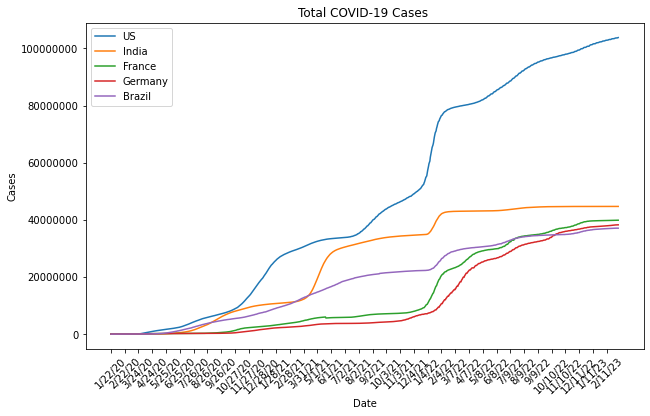

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for i in range(5):
    x = Dataframe.index
    y = Dataframe.iloc[:, i]
    
    column_name = Dataframe.columns[i]
    plt.plot(x,y, label = column_name)

plt.xlabel('Date')
plt.ylabel('Cases')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Total COVID-19 Cases ')


plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gca().set_xticks(Dataframe.index[::31])  # Set ticks every month

plt.legend()

plt.show()

## Part 1: Extract Seasonal Components

Recall from lecture that an **additive** Seasonal Decomposition model decomposes a time series $Y(t)$ into the components
$$
Y(t) = T(t) + S(t) + I(t),
$$
where $T(t)$ represents the trend, $S(t)$ represents the seasonal pattern, and $I(t)$ represents irregular data (we are **ignoring cycles** in this decomposition). For the remainder of the assignment, we will work with the seasonal components $S(t)$ to understand the similarities among the seasonal patterns of the five time series from Part 0.

1)  Create a function `sea_decomp` that takes as input a `pandas Dataframe` as created in Part 0 and outputs another `pandas Dataframe`, where:
   - the output `Dataframe` has the same shape as the input;
   - the index of the output `DataFrame` is a `pandas DatetimeIndex` as before;
   - the values of the output `DataFrame` are the seasonal components $S(t)$ of the columns in the input `Dataframe` and in the same order; and
   - the DataFrame doesn't contain any `NaN` values.

     Please utilize the `seasonal_decompose` function from the `statsmodels` Python package to decompose the time series.

<br/>

2)  Using the `Dataframe` returned from the `sea_decomp` function, plot, in a **single figure**, **six plots**, with the **first plot** containing one line for each of the 5 computed seasonal components, where the $x$-axis is the *date* and the $y$-axis is the seasonal component. The remaining **five plots** should be each seasonal component individually. You can utilize the `matplotlib.pyplot` function `subplots` to create the composite figure. Please **label the subplots** so that it is clear which country each plot is visualizing.

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

##### 1.

In [38]:
def sea_decomp(df):
    decomposed_data = pd.DataFrame()
    
    for col in df.columns:
        result = seasonal_decompose(df[col], model="additive", period = 12)
        
        decomposed_data[col] = result.seasonal
    
    decomposed_data = decomposed_data.dropna() 
    
    #print(decomposed_data.isnull().sum())
    return decomposed_data

In [39]:
seasonality = sea_decomp(Dataframe)
seasonality 

,US,India,France,Germany,Brazil
1/22/20,3475.176294,291.600592,2269.634041,2487.108061,116.729366
1/23/20,3609.359805,297.477808,2760.093704,-2765.365787,-1744.079145
1/24/20,-1972.840107,239.986230,3906.246186,-3343.506301,-1662.146964
1/25/20,-540.592323,211.799173,3506.025441,-3014.996992,-1195.420900
1/26/20,-1032.700479,-444.177334,-2645.950179,-1727.773588,389.528568
...,...,...,...,...,...
3/5/23,-320.551986,498.387826,4211.368526,1638.968433,-1576.363719
3/6/23,2783.440922,604.064244,640.618083,1496.597866,876.424402
3/7/23,3475.176294,291.600592,2269.634041,2487.108061,116.729366
3/8/23,3609.359805,297.477808,2760.093704,-2765.365787,-1744.079145


##### 2.

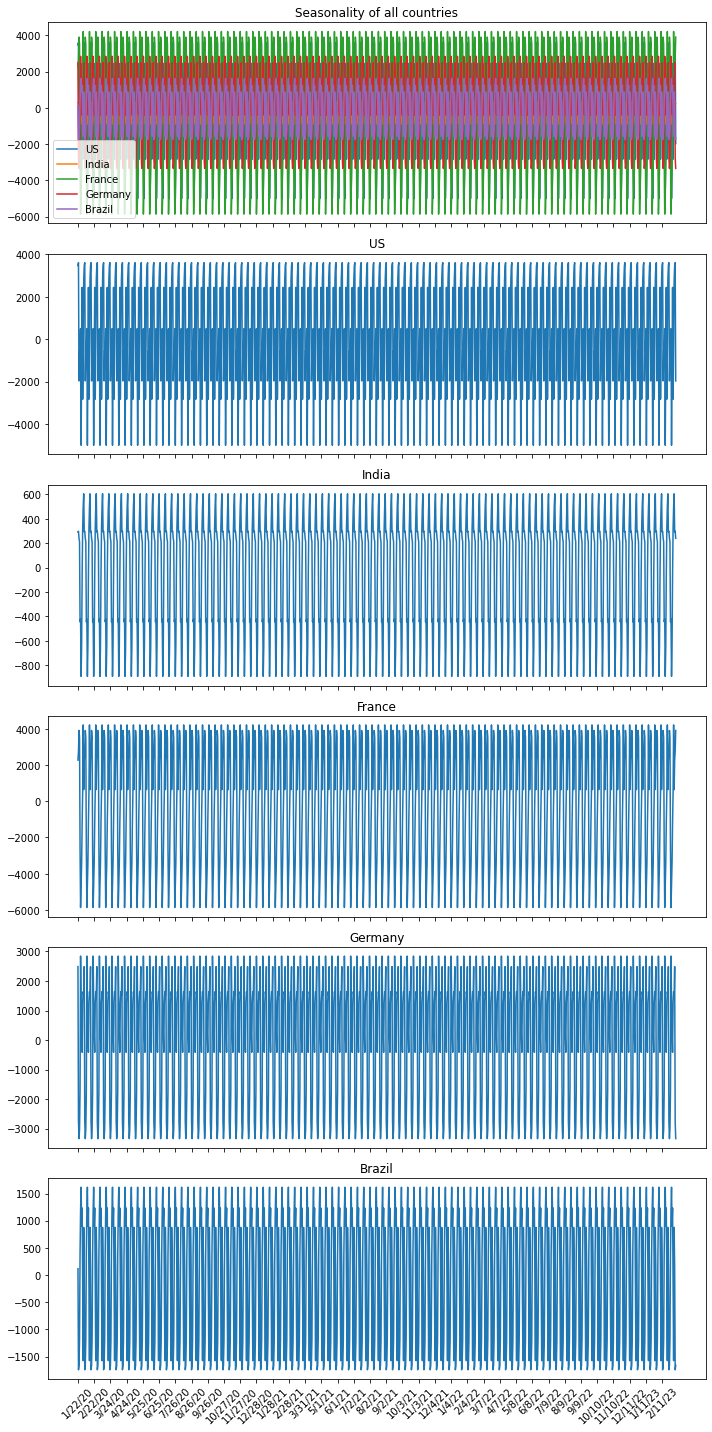

In [40]:
fig, axs = plt.subplots(6,figsize=(10, 20), sharex=True)
x = seasonality.index
    
for i in range(5):
    y = seasonality.iloc[:, i]
    
    column_name = seasonality.columns[i]
    axs[0].plot(x,y, label = column_name)

axs[0].legend()
axs[0].set_title("Seasonality of all countries")

# individual countries
for i in range(5):
    y = seasonality.iloc[:, i]
    column_name = seasonality.columns[i]
    
    axs[i+1].plot(x,y)
    axs[i+1].set_title(column_name)
    axs[i+1].tick_params(axis='x', rotation=45) 
    axs[i+1].set_xticks(seasonality.index[::31])
    
plt.tight_layout() 
plt.show()

## Part 2: Time Series Similarities

Having computed the seasonal components of the time series in Part 1, we can answer questions like, *"Which country in the top 5 countries is the most similar to Country A in terms of seasonal patterns?"*. In addition to the seasonal components, we also need **similarity measures** for time series to answer such questions.

### Part 2.1 Euclidean Distance

Recall that the **Euclidean distance** between two vectors $\mathbf{x},\mathbf{y}\in\mathbb{R}^n$ is the **norm** (length) of the vector $\mathbf{x}-\mathbf{y}$:

$$
d(\mathbf{x},\mathbf{y}) = \Vert\mathbf{x}-\mathbf{y}\Vert^2 = \sqrt{\sum_{i=1}^n (x_i-y_i)^2}
$$

1. Create a function `calc_euclidean_dist` that accepts as input a `pandas Dataframe` whose columns are time series for each country and that returns a  `pandas Dataframe` that corresponds to the *symmetric matrix* of all **pairwise Euclidean distances** of these time series. The *index* and *column names* of the returned `Dataframe` should be the top 5 countries maintained in the same order.

2. Use the above function to calculate the pairwise Euclidean distance for the extracted seasonal components from Part 1.2.

###### 1.

In [41]:
def calc_euclidean_dist(df):
    euclidean_matrix = pd.DataFrame(index = df.columns,columns = df.columns)
    for country1 in df.columns:
        for country2 in df.columns:
            total_distance = 0 
            for i in range(len(df)):
                total_distance += (df[country1][i]-df[country2][i])**2
            euclidean = (total_distance)**(0.5)
            euclidean_matrix.at[country1, country2] = euclidean
    return euclidean_matrix

In [42]:
euclidean_seasonal = calc_euclidean_dist(seasonality)
euclidean_seasonal

,US,India,France,Germany,Brazil
US,0.0,79686.026761,120068.531664,110285.343483,99957.587226
India,79686.026761,0.0,100325.000797,74674.266482,51664.994925
France,120068.531664,100325.000797,0.0,157263.184989,149536.526828
Germany,110285.343483,74674.266482,157263.184989,0.0,58598.450264
Brazil,99957.587226,51664.994925,149536.526828,58598.450264,0.0


### Part 2.2 Cosine Similarity

Another commonly used similarity measure is **Cosine similarity**, defined as 

$$
S_C(\mathbf{x},\mathbf{y}) = \cos(\theta)=\dfrac{\langle\mathbf{x},\mathbf{y}\rangle}{\Vert\mathbf{x}\Vert\Vert\mathbf{y}\Vert},
$$
where $\langle\cdot,\cdot\rangle$ is the standard **inner product** and $\Vert\cdot\Vert$ is the **Euclidean norm**.

1. Create a function `calc_cos_sim` that accepts as input a `pandas Dataframe` whose columns are time series for each country and that returns a  `pandas Dataframe` that corresponds to the *symmetric matrix* of all **pairwise Cosine similarities** of these time series. The *index* and *column names* of the returned `Dataframe` should be the top 5 countries maintained in the same order.

2. Use the above function to calculate the pairwise Cosine similarities for the extracted seasonal components from Part 1.2.

##### 2.

In [43]:
def calc_cos_sim(df):
    cosine_similarity = pd.DataFrame(index=df.columns, columns=df.columns)
    
    for country1 in df.columns:
        for country2 in df.columns:
            inner_product = sum(df[country1] * df[country2])
            normX = sum(df[country1]**2)**0.5
            normY = sum(df[country2]**2)**0.5
            cosine_similarity.at[country1, country2] = inner_product / (normX * normY)
            
    return cosine_similarity

In [44]:
cosine_seasonal = calc_cos_sim(seasonality)
cosine_seasonal

,US,India,France,Germany,Brazil
US,1.0,0.516782,0.30212,0.037375,-0.123461
India,0.516782,1.0,0.851295,-0.094541,-0.635079
France,0.30212,0.851295,1.0,-0.417535,-0.864979
Germany,0.037375,-0.094541,-0.417535,1.0,0.573865
Brazil,-0.123461,-0.635079,-0.864979,0.573865,1.0


## Part 3: Dynamic Time Warping (DTW) Cost

The cost of aligning two time series can also be used as a similarity measure. Two time series are *more* similar if less cost is incurred during alignment. One commonly used alignment cost is the **Dynamic Time Warping (DTW) cost**, which we will explore in this problem.

Recall from Lecture 6 that the DTW cost $DTW(\mathbf{x},\mathbf{y})$ is defined by the **recurrence relations**
$$
\begin{align*}
DTW(1,1) &= d(x_1,y_1)\\
DTW(i,j) &= d(x_i,y_j)+\min\left\{
\begin{array}{ll}
DTW(i,j-1)&\mathrm{Repeat}\; x_i\\
DTW(i-1,j)&\mathrm{Repeat}\; y_i\\
DTW(i-1,j-1)&\mathrm{Both\;proceed}
\end{array}\right.,
\end{align*}
$$

where $d(x_i,y_j)$ is Euclidean distance.

1. Create a function `calc_pairwise_dtw_cost` that computes the DTW cost for two time series $\mathbf{x}$ and $\mathbf{y}$. You may utilize the the pseudocode available on [Wikipedia](https://en.wikipedia.org/wiki/Dynamic_time_warping#Implementation) to aid you in your implementation, but please note that you will need to **adjust the index ranges** to account for Python using zero indexing. Your function should implement two **keyword arguments**:
   - `rep_matrix` - A Boolean value, that if `True`, should return a $m\times n$ `numpy ndarray` of DTW costs, where `m=len(x)` and `n=len(y)`. If `rep_matrix=False`, the function should return the total DTW cost for aligning $\mathbf{x}$ and $\mathbf{y}$.
   - `take_root` - A Boolean value, that if `True` (and `rep_matrix=False`), should return the square root of the total DTW cost for aligning $\mathbf{x}$ and $\mathbf{y}$.
2. Create a function `calc_dtw_cost` that accepts as input a `pandas Dataframe` whose columns are time series for each country and that returns a  `pandas Dataframe` that corresponds to the *symmetric matrix* of all **pairwise DTW costs** of these time series. The *index* and *column names* of the returned `Dataframe` should be the top 5 countries maintained in the same order.
3. Use the above function to calculate the pairwise DTW costs for the extracted seasonal components from Part 1.2. **Please take the square root
    so that we can compare it with the Euclidean distances computed in Part 2.1.**
4. What can you say about the similarities among these seasonal patterns? Do the results of the pairwise Euclidean Distance, Cosine similarity, and DTW cost calculations tell the same story? Why or why not?

###### 1.

In [45]:
def calc_pairwise_dtw_cost(x, y, rep_matrix=False, take_root=False):
    X_length = len(x)
    Y_length = len(y)
    pairwise_matrix = np.empty((X_length, Y_length))
    
    # initialize first column
    for i in range(X_length):
        pairwise_matrix[i][0] = (x[i] - y[0])**2
    
    # initialize first row
    for j in range(Y_length):
        pairwise_matrix[0][j] = (x[0] - y[j])**2
       
    # fill the matrix
    for i in range(1, X_length):
        for j in range(1, Y_length):
            pairwise_matrix[i][j] = (x[i] - y[j])**2 + min(pairwise_matrix[i-1][j], pairwise_matrix[i][j-1], pairwise_matrix[i-1][j-1])
    
    if rep_matrix == True:
        return pairwise_matrix
    else:
        cost = pairwise_matrix[X_length - 1][Y_length - 1]
        if take_root == True:
            return cost**0.5
        else:
            return cost

###### 2.

In [46]:
def calc_dtw_cost(df, rep_matrix=False, take_root=False):
    DTW_Matrix = pd.DataFrame(index=df.columns, columns=df.columns)
    
    for country1 in df.columns:
        for country2 in df.columns:
            x = df[country1].values
            y = df[country2].values
            DTW_Matrix.at[country1, country2] = calc_pairwise_dtw_cost(x, y, rep_matrix, take_root)
    
    return DTW_Matrix

##### 3.

In [47]:
DTW = calc_dtw_cost(seasonality, rep_matrix = False, take_root = True)
DTW

,US,India,France,Germany,Brazil
US,0.0,19803.57317,51161.858799,47385.87626,41867.699332
India,19803.57317,0.0,23859.081013,18353.484022,16379.822178
France,51161.858799,23859.081013,0.0,46133.511949,44223.12308
Germany,47385.87626,18353.484022,46133.511949,0.0,41043.938494
Brazil,41867.699332,16379.822178,44223.12308,41043.938494,0.0


###### 4.

The DTW and the eulclidean distance are similar in terms of ranking of ranking pairs of each country. This would mean the India and Brazil seasonal patterns will be the most similar. However, the cosine similarity doesn't tell the same story as the other two because the magnititude might of the seasonality series might be different.